In [16]:
import os
import pandas as pd

from eval_utils import get_metrics_dict_for_path_selection_type, plot_bar_chart, get_simple_eval_metrics

ROOT = "/sailhome/esui/cs224u_final_project"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


intersection max: 0.9466666666666667
union max: 0.9466666666666667
longest max: 0.9466666666666667
majority max: 0.9466666666666667
double_forward_negation max: 0.9466666666666667
forward_negation max: 0.94
single_backward_neg max: 0.9266666666666666
backward_negation max: 0.9266666666666666
single_forward_neg max: 0.9266666666666666
baseline max: 0.9233333333333333
single_baseline max: 0.92
direction max: 0.91
double_backward_negation max: 0.91
single_forward max: 0.9033333333333333
all max: 0.86
forward_randomized_order max: 0.8466666666666667
forward_all max: 0.8466666666666667
single_backward max: 0.7766666666666666
backward_all max: 0.72
backward_randomized_order max: 0.6766666666666666


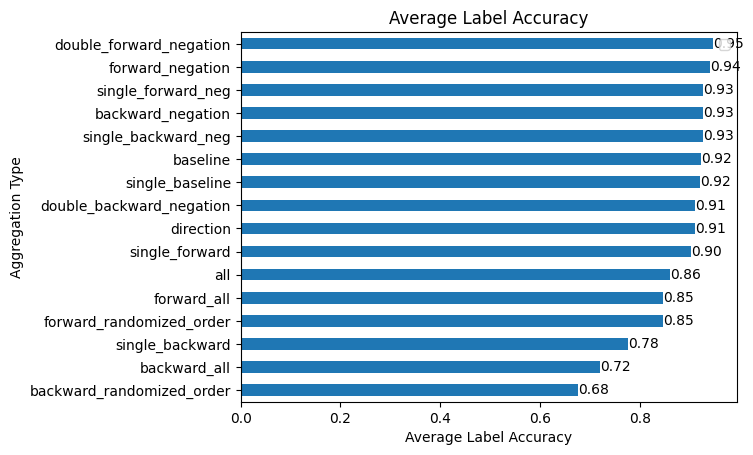

In [9]:
path_selection = "longest"
aggregate_path_glob = f'{ROOT}/prontoqa_output/fictional/aggregated/**/merge_answer_hard_*_path_select_{path_selection}.pkl'
restrict_aggregation_types = [] #['single_baseline', 'single_forward', 'single_backward', 'single_forward_neg', 'single_backward_neg', 'baseline', 'forward_negation', 'double_forward_negation', 'forward_randomized_order', 'backward_negation', 'double_backward_negation', 'backward_randomized_order', 'direction']
metrics_dict, aggregation_types, merge_cot_types = get_metrics_dict_for_path_selection_type(aggregate_path_glob, path_selection, restrict_aggregation_types=restrict_aggregation_types)
columns = ['Aggregation Type'] + merge_cot_types

metric = "avg_label_acc"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types, "Average Label Accuracy")

union max: 0.3933333333333333
longest max: 0.3933333333333333
intersection max: 0.39
majority max: 0.39
double_forward_negation max: 0.3933333333333333
forward_negation max: 0.39
single_forward_neg max: 0.38333333333333336
single_backward_neg max: 0.38
single_forward max: 0.37
single_baseline max: 0.36666666666666664
direction max: 0.36333333333333334
backward_negation max: 0.36
baseline max: 0.34
forward_randomized_order max: 0.2833333333333333
double_backward_negation max: 0.27666666666666667
single_backward max: 0.13666666666666666
backward_randomized_order max: 0.13333333333333333


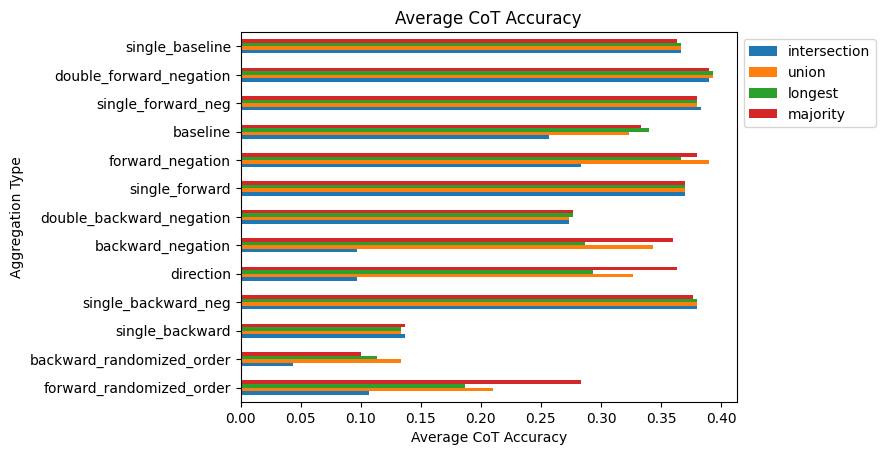

In [4]:
metric = "avg_cot_acc"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


none max: 0.9466666666666667
double_forward_negation max: 0.9466666666666667
forward_all max: 0.9466666666666667
all max: 0.9466666666666667
double_baseline_negation max: 0.9433333333333334
forward_negation max: 0.9266666666666666
single_forward_neg max: 0.9266666666666666
single_baseline max: 0.9166666666666666
baseline max: 0.9166666666666666
single_baseline_neg max: 0.9133333333333333
direction max: 0.91
single_forward max: 0.9033333333333333
forward_randomized_order max: 0.8866666666666667
backward_negation max: 0.8666666666666667
double_backward_negation max: 0.8233333333333334
backward_all max: 0.79
backward_randomized_order max: 0.7866666666666666
single_backward max: 0.7766666666666666
single_backward_neg max: 0.76


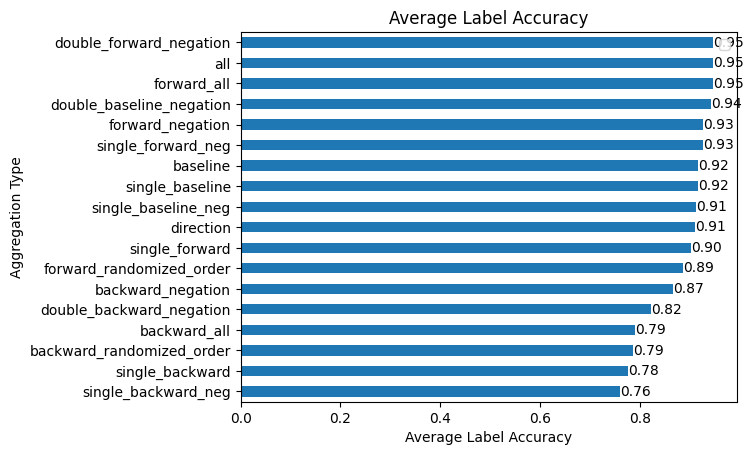

In [17]:
path_selection = "heaviest"
aggregate_path_glob = f'{ROOT}/prontoqa_output/fictional/aggregated/**/merge_answer_hard_merge_cot_none_path_select_{path_selection}.pkl'
metrics_dict, aggregation_types, merge_cot_types = get_metrics_dict_for_path_selection_type(aggregate_path_glob, path_selection)

columns = ['Aggregation Type'] + merge_cot_types

metric = "avg_label_acc"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

none max: 0.3933333333333333
double_forward_negation max: 0.3933333333333333
forward_negation max: 0.38666666666666666
single_forward_neg max: 0.38
single_forward max: 0.37
direction max: 0.3566666666666667
baseline max: 0.3566666666666667
all max: 0.35333333333333333
backward_negation max: 0.35
single_baseline max: 0.35
single_baseline_neg max: 0.3433333333333333
double_baseline_negation max: 0.33666666666666667
forward_all max: 0.31333333333333335
forward_randomized_order max: 0.2866666666666667
backward_all max: 0.21333333333333335
backward_randomized_order max: 0.17666666666666667
single_backward_neg max: 0.14
single_backward max: 0.13666666666666666
double_backward_negation max: 0.13333333333333333


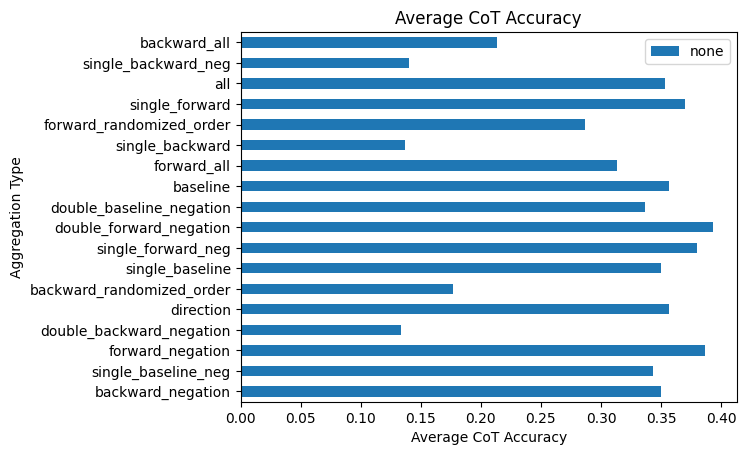

In [18]:
metric = "avg_cot_acc"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

## Individual eval

In [24]:
FILES = {
        'baseline_seed1234': 'baseline_1_shot_temp_0.0_seed_1234.pkl',
        'baseline_seed5678': 'baseline_1_shot_temp_0.7_seed_5678.pkl',
        'baseline_seed910': 'baseline_1_shot_temp_0.7_seed_910.pkl',
        'baseline_neg': 'baseline_negated_1_shot_temp_0.0_seed_1234.pkl',
        'forward_ltsbs': 'forward_ltsbs_1_shot_temp_0.0_seed_1234.pkl',
        'forward_neg_ltsbs': 'forward_negated_ltsbs_1_shot_temp_0.0_seed_1234.pkl',
        'forward_1': 'forward_ltsbs_randomized_order_1_shot_temp_0.0_seed_1234.pkl',
        'forward_2': 'forward_ltsbs_randomized_order_1_shot_temp_0.0_seed_12345.pkl',
        'backward_ltsbs': 'backward_ltsbs_1_shot_temp_0.0_seed_1234.pkl',
        'backward_neg_ltsbs': 'backward_negated_ltsbs_1_shot_temp_0.0_seed_1234.pkl',
        'backward_1': 'backward_ltsbs_randomized_order_1_shot_temp_0.0_seed_1234.pkl',
        'backward_2': 'backward_ltsbs_randomized_order_1_shot_temp_0.0_seed_12345.pkl',
        'double_baseline_negation': 'double_baseline_negation/merge_answer_hard_merge_cot_none_path_select_none.pkl',
        'double_forward_negation': 'double_forward_negation/merge_answer_hard_merge_cot_none_path_select_none.pkl',
        'double_backward_negation': 'double_backward_negation/merge_answer_hard_merge_cot_none_path_select_none.pkl',
    }

OUTPUT_ROOT = "/sailhome/esui/cs224u_final_project/prontoqa_output/fictional/converted"

def get_metrics_dict_for_prompt_type(prompt_type):
    output_root = OUTPUT_ROOT
    if prompt_type == "baseline":
        path = FILES['baseline_seed1234']
    elif prompt_type in ["forward_ltsbs", "forward_neg_ltsbs", "backward_ltsbs", "backward_neg_ltsbs", "baseline_neg"]:
        path = FILES[prompt_type]
    elif prompt_type in ["double_forward_negation", "double_backward_negation", "double_baseline_negation"]:
        output_root = "/sailhome/esui/cs224u_final_project/prontoqa_output/fictional/aggregated"
        path = FILES[prompt_type]
    else:
        raise NotImplementedError(f'prompt_type {prompt_type} not queried')

    path = os.path.join(output_root, path)

    metrics_dict = get_simple_eval_metrics(path)
    return metrics_dict

def get_data_for_all_metrics(metrics_dict, prompt_types):
    data = []
    for metric in metrics_dict[prompt_types[0]].keys():
        data_metric = [metric]
        for prompt_type in prompt_types:
            data_metric.append(metrics_dict[prompt_type][metric])
        data.append(data_metric)
    return data

In [25]:
PROMPT_TYPES = ["baseline", "baseline_neg", "forward_ltsbs", "forward_neg_ltsbs", "backward_ltsbs", "backward_neg_ltsbs", "double_baseline_negation", "double_forward_negation", "double_backward_negation"]
columns = ["metric"] + PROMPT_TYPES
metrics_dict = {}
for prompt_type in PROMPT_TYPES:
    metrics_dict[prompt_type] = get_metrics_dict_for_prompt_type(prompt_type)

data = get_data_for_all_metrics(metrics_dict, PROMPT_TYPES)

metrics_df = pd.DataFrame(
            columns=columns,
            data=data,
)

print(metrics_df)

metrics_df.plot(x='metric',
    kind='barh',
    stacked=False,
    title="individual eval no path selection"
)

              metric  baseline  baseline_neg  forward_ltsbs   
0      avg_label_acc  0.916667      0.913333       0.903333  \
1        avg_cot_acc  0.303333      0.306667       0.330000   
2  avg_cot_precision  0.763319      0.764926       0.767877   
3     avg_cot_recall  0.819740      0.817821       0.827677   
4         avg_cot_f1  0.781709      0.782371       0.788543   

   forward_neg_ltsbs  backward_ltsbs  backward_neg_ltsbs   
0           0.926667        0.776667            0.760000  \
1           0.336667        0.060000            0.066667   
2           0.780013        0.638747            0.624134   
3           0.835108        0.657937            0.662309   
4           0.798937        0.632611            0.626049   

   double_baseline_negation  double_forward_negation  double_backward_negation  
0                  0.943333                 0.946667                  0.823333  
1                  0.293333                 0.343333                  0.053333  
2                

OSError: Cannot save file into a non-existent directory: 'results'